In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyswarm import pso  # Optimisation PSO
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
csv_path = '../data/feature/feature.csv'
merged_df = pd.read_csv(csv_path)

In [3]:
# Target
df= merged_df.copy()
df['Direction'] = (df['Return'] > 0).astype(int)

C:\Users\33615\AppData\Local\Temp\ipykernel_25788\2721711989.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Direction', palette='coolwarm', edgecolor='black')


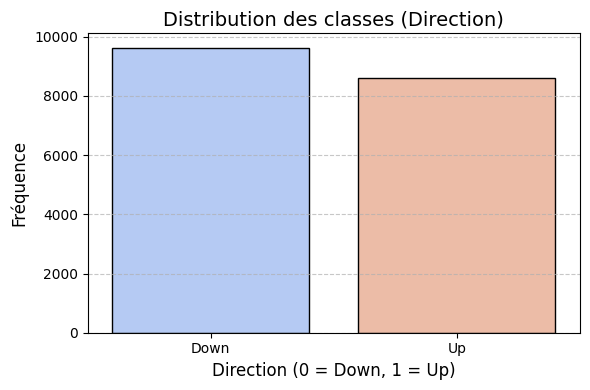

In [4]:
#Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Direction', palette='coolwarm', edgecolor='black')

plt.title('Distribution des classes (Direction)', fontsize=14)
plt.xlabel('Direction (0 = Down, 1 = Up)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.xticks([0, 1], ['Down', 'Up'], rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

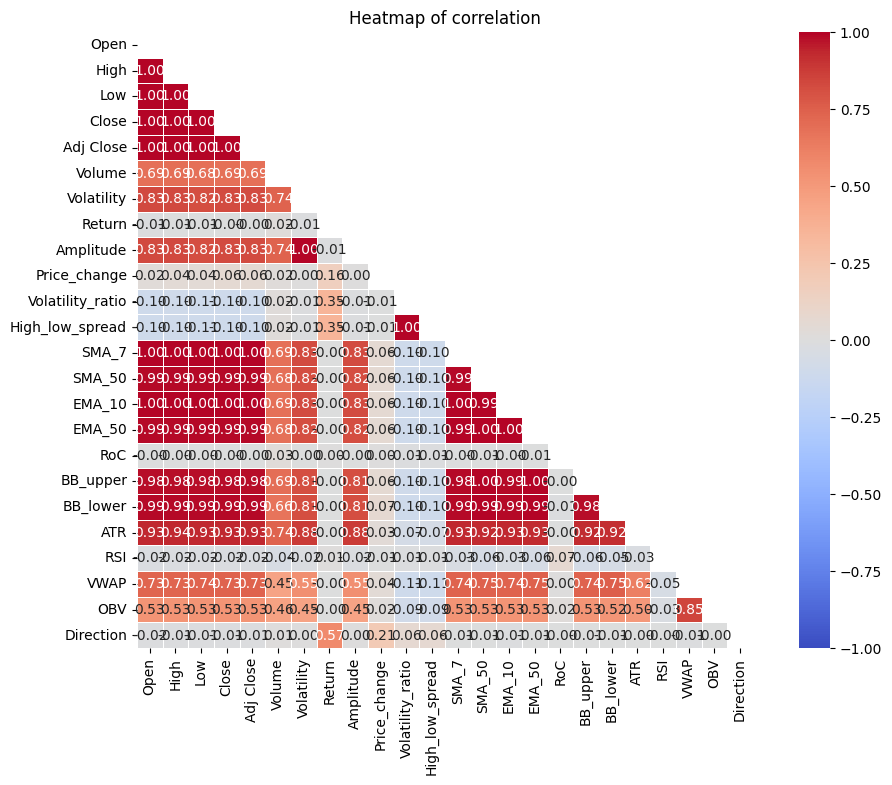

In [5]:
#Heatmap

corr_matrix = df.drop(columns=['Date', 'Crypto']).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
    linewidths=0.5, vmax=1, vmin=-1, square=True
)
plt.title("Heatmap of correlation")
plt.show()


C:\Users\33615\AppData\Local\Temp\ipykernel_25788\1709050577.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_return.index, y=corr_with_return.values, palette="coolwarm")


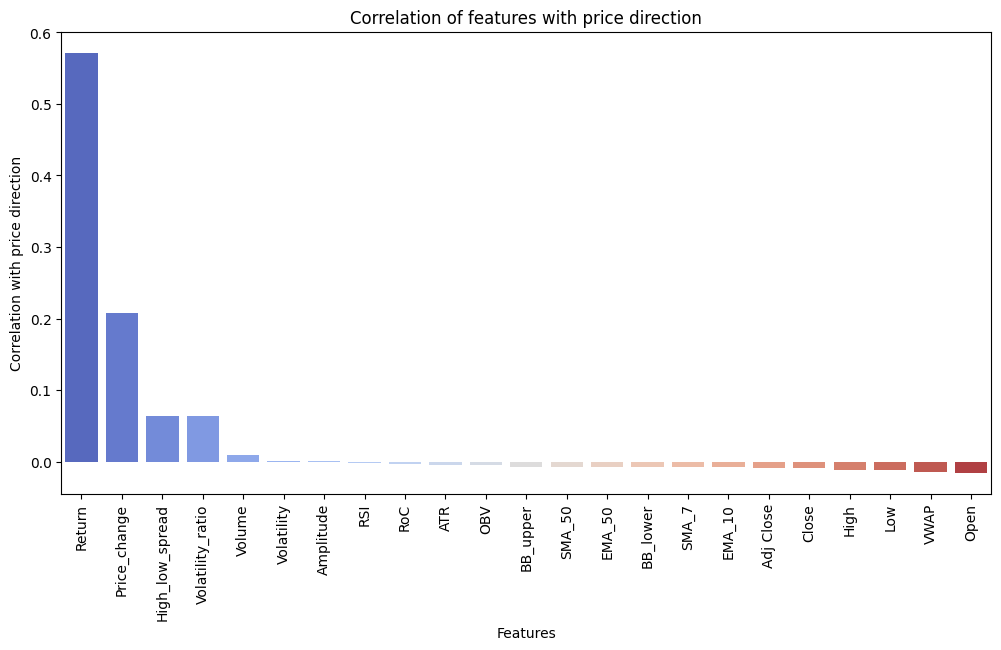

In [6]:
# Correlation with target Distribution
corr_with_return = df.drop(columns=['Date', 'Crypto']).corr()['Direction'].drop('Direction').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=corr_with_return.index, y=corr_with_return.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with price direction")
plt.title("Correlation of features with price direction")
plt.show()


In [ ]:
# RandomForestClassifier

features = ['Open', 'Volume', 'Volatility', 'Return', 'Amplitude', 'Price_change', 'Volatility_ratio',
            'High_low_spread', 'RoC', 'ATR', 'RSI', 'VWAP', 'OBV']
df['Direction'] = (df['Return'] > 0).astype(int)

np.random.seed(42)
df[features] += np.random.normal(0, 0.05, df[features].shape)  

X = df[features].values
y = df['Direction'].values  # Target binaire

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

tscv = TimeSeriesSplit(n_splits=5)
rf_accuracy_scores = []

In [ ]:
# PSO
def evaluate_rf(hyperparams):
    """
    Fonction d'évaluation du modèle Random Forest pour l'optimisation PSO.
    """
    n_estimators, max_depth = int(hyperparams[0]), int(hyperparams[1])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion='entropy', random_state=42, n_jobs=-1)
    
    rf_model = model.fit(X_resampled, y_resampled)
    y_pred = rf_model.predict(X_resampled)
    
    return 1 - accuracy_score(y_resampled, y_pred)  

lb = [10, 5]
ub = [100, 15] 

best_hyperparams, _ = pso(evaluate_rf, lb, ub, swarmsize=10, maxiter=5)

n_estimators_opt, max_depth_opt = int(best_hyperparams[0]), int(best_hyperparams[1])

In [30]:
lb = [10, 5]
ub = [100, 15] 

best_hyperparams, _ = pso(evaluate_rf, lb, ub, swarmsize=10, maxiter=5)

n_estimators_opt, max_depth_opt = int(best_hyperparams[0]), int(best_hyperparams[1])

#Retraining with best params

optimized_rf = RandomForestClassifier(n_estimators=n_estimators_opt, max_depth=max_depth_opt, criterion='entropy', random_state=42, n_jobs=-1)

for train_index, test_index in tscv.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    optimized_rf.fit(X_train, y_train)

    y_train_pred = optimized_rf.predict(X_train)
    y_test_pred = optimized_rf.predict(X_test)

    rf_accuracy_scores.append(accuracy_score(y_test, y_test_pred))

accuracy_avg = np.mean(rf_accuracy_scores)
print(f"\nAccuracy moyen du Random Forest optimisé : {accuracy_avg:.6f}")

Stopping search: maximum iterations reached --> 5

Accuracy moyen du Random Forest optimisé : 0.553209


In [ ]:
#Save model

model_filename = 'direction_model.pkl'
joblib.dump(optimized_rf, model_filename)
